# 0.0. IMPORTS

In [1]:
import math 
import numpy as np
import pandas as pd
import inflection
import datetime

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.1. Helper Functions

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False)

In [4]:
#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
376132,523,1,2014-08-04,16165,1776,1,1,0,1,c,c,50.0,11.0,2013.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print ( 'Number of Rows: {}' .format(df1.shape[0] ) )
print ( 'Number of Cols: {}' .format(df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
236414,40,3,2014-12-31,1675,257,1,0,0,1,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [12]:
#competition_distance   
df1.competition_distance.fillna(200000., inplace=True)

#competition_open_since_month 
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition_open_since_year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2_since_week
df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)

#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

# substitui os 0 para '', assim não será necessário um dos if's do is_promo
df1['promo_interval'].replace(0, '', inplace=True)
# mesmo aqui
df1['promo_interval'].fillna('', inplace=True) 

# obtem a abreviatura do mês
df1['month_map'] = df1['date'].dt.strftime("%b") 

# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int32
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

df1['is_promo'] = df1['is_promo'].astype( 'int64' )

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m.head(5)

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723


### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

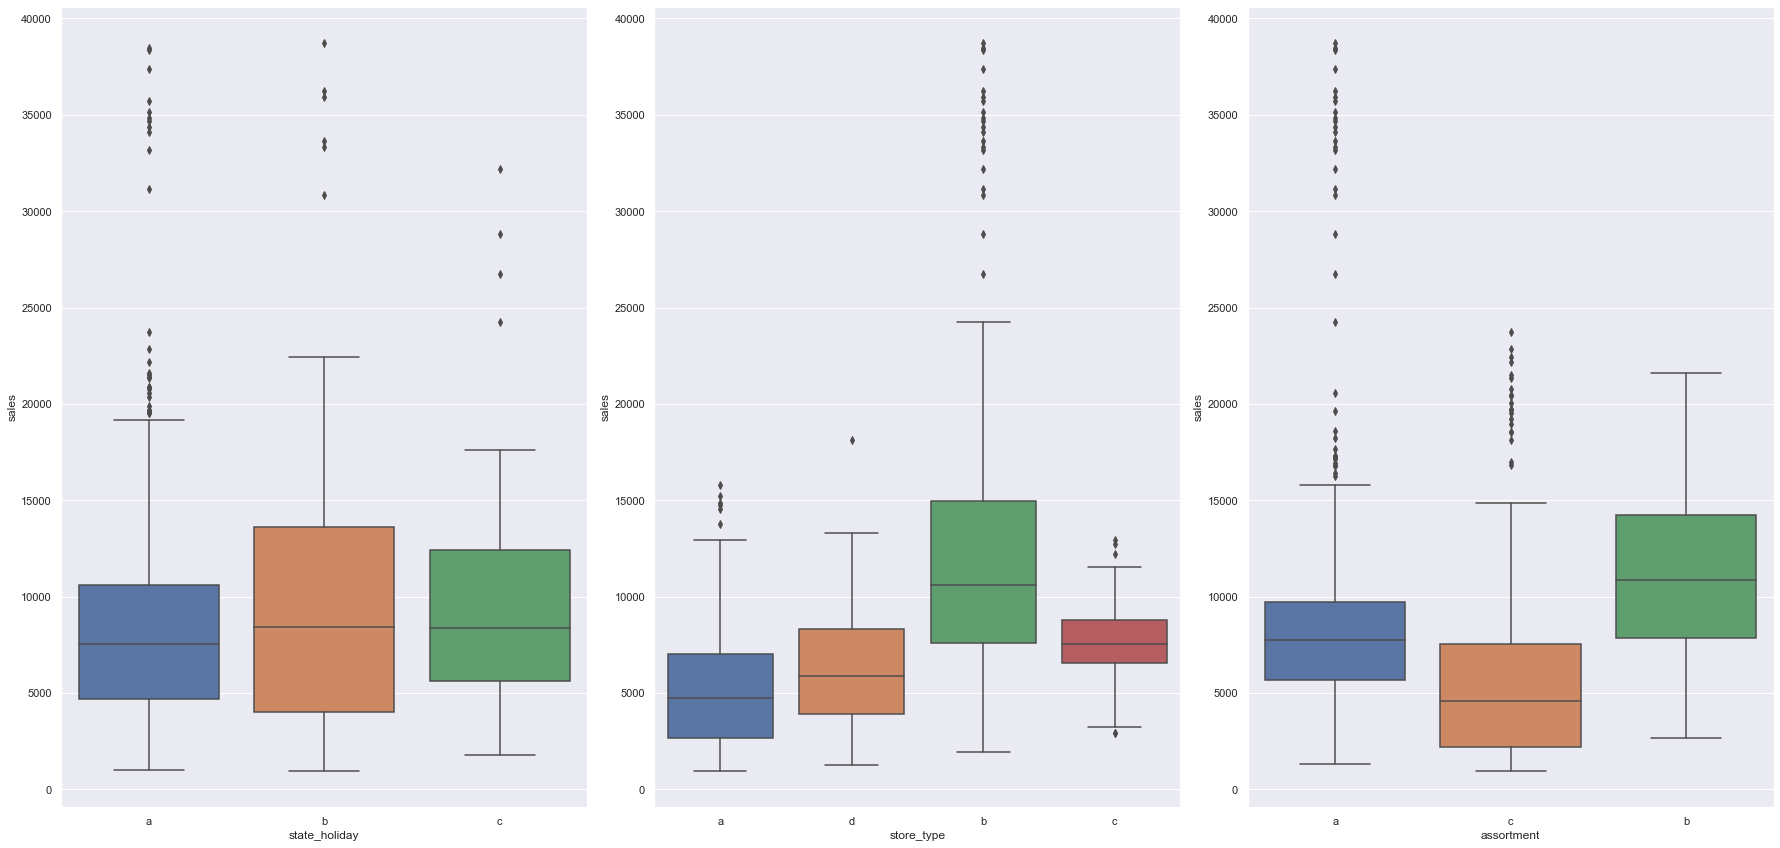

In [18]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)] 

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data= aux1)

plt.subplot(1,3,3)
plt.tight_layout()
sns.boxplot( x='assortment', y='sales', data= aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

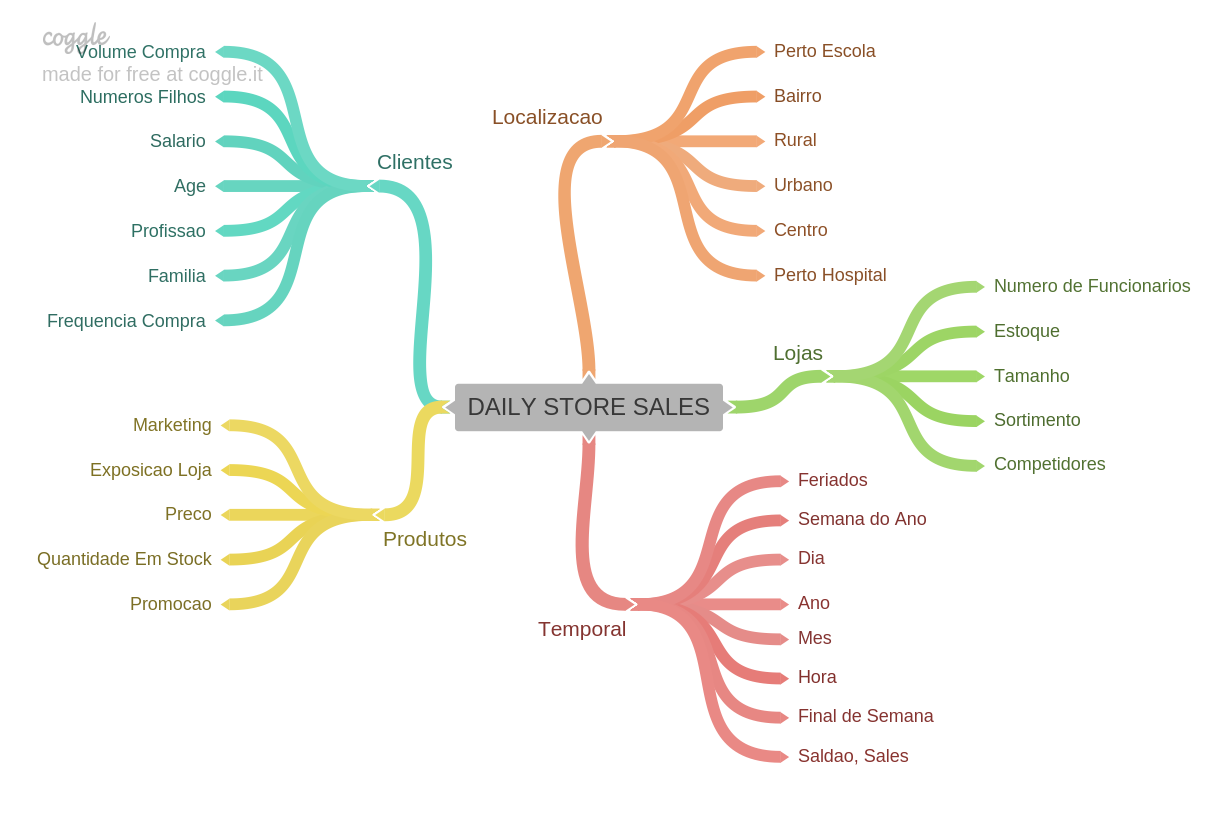

In [20]:
Image('img\MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses


### 2.2.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com menor porte deveriam vender menos. 

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.

### 2.2.3 Hipoteses tempo

**1.** Lojas que que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.3. Lista Final de Hipóteses

### Prioridade serão as hipósteses que já possuem dados para serem validadas

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com mais dias de promoção deveriam vender mais.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda  x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda  x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [23]:
df2.head(4)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


In [28]:
df2.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
585355,766,4,2014-01-23,6072,484,1,1,regular_day,0,d,extended,9820.0,1,2014,0,4,2014,,Jan,0,2014,1,23,4,2014-03,2014-01-01,0,2014-01-20,0
479006,342,1,2014-04-28,12842,943,1,1,regular_day,0,d,extended,15770.0,4,2014,1,40,2014,"Jan,Apr,Jul,Oct",Apr,1,2014,4,28,18,2014-17,2014-04-01,0,2014-09-29,-22
924707,43,7,2013-03-24,0,0,0,0,regular_day,0,d,basic,4880.0,3,2013,1,37,2009,"Jan,Apr,Jul,Oct",Mar,0,2013,3,24,12,2013-11,2013-03-01,0,2009-09-07,184
942211,822,6,2013-03-09,6719,640,1,0,regular_day,0,a,extended,410.0,11,2010,1,48,2010,"Mar,Jun,Sept,Dec",Mar,1,2013,3,9,10,2013-09,2010-11-01,28,2010-11-22,119
415001,1007,3,2014-06-25,4444,609,1,0,regular_day,0,c,extended,4180.0,9,2012,0,26,2014,,Jun,0,2014,6,25,26,2014-25,2012-09-01,22,2014-06-23,0
366677,395,4,2014-08-14,3419,506,1,0,regular_day,1,a,basic,3620.0,2,2013,0,33,2014,,Aug,0,2014,8,14,33,2014-32,2013-02-01,18,2014-08-11,0
987791,687,7,2013-01-27,0,0,0,0,regular_day,0,d,extended,2770.0,1,2013,0,4,2013,,Jan,0,2013,1,27,4,2013-03,2013-01-01,0,2013-01-21,0
621017,748,7,2013-12-22,0,0,0,0,regular_day,0,d,basic,2380.0,3,2010,1,14,2011,"Jan,Apr,Jul,Oct",Dec,0,2013,12,22,51,2013-50,2010-03-01,46,2011-03-28,142
242812,983,4,2014-12-25,0,0,0,0,christmas,1,a,basic,40.0,3,2014,1,1,2014,"Jan,Apr,Jul,Oct",Dec,0,2014,12,25,52,2014-51,2014-03-01,9,2013-12-30,51
76494,675,7,2015-05-24,0,0,0,0,regular_day,0,a,basic,2100.0,8,2013,1,14,2011,"Jan,Apr,Jul,Oct",May,0,2015,5,24,21,2015-20,2013-08-01,22,2011-03-28,216


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [44]:
df3.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
223477,478,1,2015-01-12,8378,784,1,1,regular_day,0,d,extended,1940.0,3,2012,0,3,2015,,Jan,0,2015,1,12,3,2015-02,2012-03-01,34,2015-01-12,0
303161,470,2,2014-10-21,14404,1872,1,1,regular_day,0,a,extended,50.0,10,2014,0,43,2014,,Oct,0,2014,10,21,43,2014-42,2014-10-01,0,2014-10-20,0
724786,822,5,2013-09-20,5638,540,1,0,regular_day,0,a,extended,410.0,11,2010,1,48,2010,"Mar,Jun,Sept,Dec",Sep,0,2013,9,20,38,2013-37,2010-11-01,35,2010-11-22,147
181676,1047,4,2015-02-19,5894,580,1,1,regular_day,0,a,basic,3750.0,2,2015,1,45,2009,"Feb,May,Aug,Nov",Feb,1,2015,2,19,8,2015-07,2015-02-01,0,2009-11-02,276
515798,339,3,2014-03-26,3742,582,1,0,regular_day,0,a,extended,2280.0,3,2014,1,10,2013,"Mar,Jun,Sept,Dec",Mar,1,2014,3,26,13,2014-12,2014-03-01,0,2013-03-04,55
978714,530,1,2013-02-04,3542,419,1,1,regular_day,0,a,extended,18160.0,2,2013,0,6,2013,,Feb,0,2013,2,4,6,2013-05,2013-02-01,0,2013-02-04,0
383164,1101,1,2014-07-28,14240,1127,1,1,regular_day,1,d,extended,4060.0,9,2012,0,31,2014,,Jul,0,2014,7,28,31,2014-30,2012-09-01,23,2014-07-28,0
891967,753,2,2013-04-23,9584,828,1,1,regular_day,0,d,extended,540.0,11,2012,1,35,2010,"Mar,Jun,Sept,Dec",Apr,0,2013,4,23,17,2013-16,2012-11-01,5,2010-08-23,139
69204,75,6,2015-05-30,6417,674,1,0,regular_day,0,d,extended,22440.0,12,2013,0,22,2015,,May,0,2015,5,30,22,2015-21,2013-12-01,18,2015-05-25,0
654256,537,5,2013-11-22,5178,582,1,1,regular_day,0,a,basic,600.0,5,2002,1,1,2012,"Jan,Apr,Jul,Oct",Nov,0,2013,11,22,47,2013-46,2002-05-01,140,2011-12-26,99


## 3.1. Filtragem das Linhas

In [45]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das Colunas

In [46]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [47]:
df3.sample(10)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
544904,455,5,2014-02-28,8027,0,regular_day,0,d,extended,7660.0,9,2010,0,9,2014,0,2014,2,28,9,2014-08,2010-09-01,42,2014-02-24,0
938357,313,2,2013-03-12,5249,0,regular_day,0,d,extended,14160.0,3,2013,0,11,2013,0,2013,3,12,11,2013-10,2013-03-01,0,2013-03-11,0
661547,23,5,2013-11-15,5347,0,regular_day,0,d,basic,4060.0,8,2005,0,46,2013,0,2013,11,15,46,2013-45,2005-08-01,100,2013-11-11,0
886371,732,7,2013-04-28,2156,0,regular_day,0,a,extended,35280.0,4,2013,0,17,2013,0,2013,4,28,17,2013-16,2013-04-01,0,2013-04-22,0
106066,142,1,2015-04-27,6103,1,regular_day,0,a,basic,1090.0,7,2002,0,18,2015,0,2015,4,27,18,2015-17,2002-07-01,156,2015-04-27,0
489075,376,6,2014-04-19,7067,0,regular_day,0,a,basic,160.0,8,2012,0,16,2014,0,2014,4,19,16,2014-15,2012-08-01,20,2014-04-14,0
692087,458,6,2013-10-19,10005,0,regular_day,1,c,basic,3390.0,10,2013,0,42,2013,0,2013,10,19,42,2013-41,2013-10-01,0,2013-10-14,0
368593,451,2,2014-08-12,4146,0,regular_day,1,a,basic,2460.0,4,2009,1,13,2010,0,2014,8,12,33,2014-32,2009-04-01,65,2010-03-22,229
411142,493,6,2014-06-28,9006,0,regular_day,0,d,extended,1150.0,6,2014,1,14,2011,0,2014,6,28,26,2014-25,2014-06-01,0,2011-03-28,169
553459,90,4,2014-02-20,7999,1,regular_day,0,a,basic,330.0,11,2007,0,8,2014,0,2014,2,20,8,2014-07,2007-11-01,76,2014-02-17,0


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [48]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

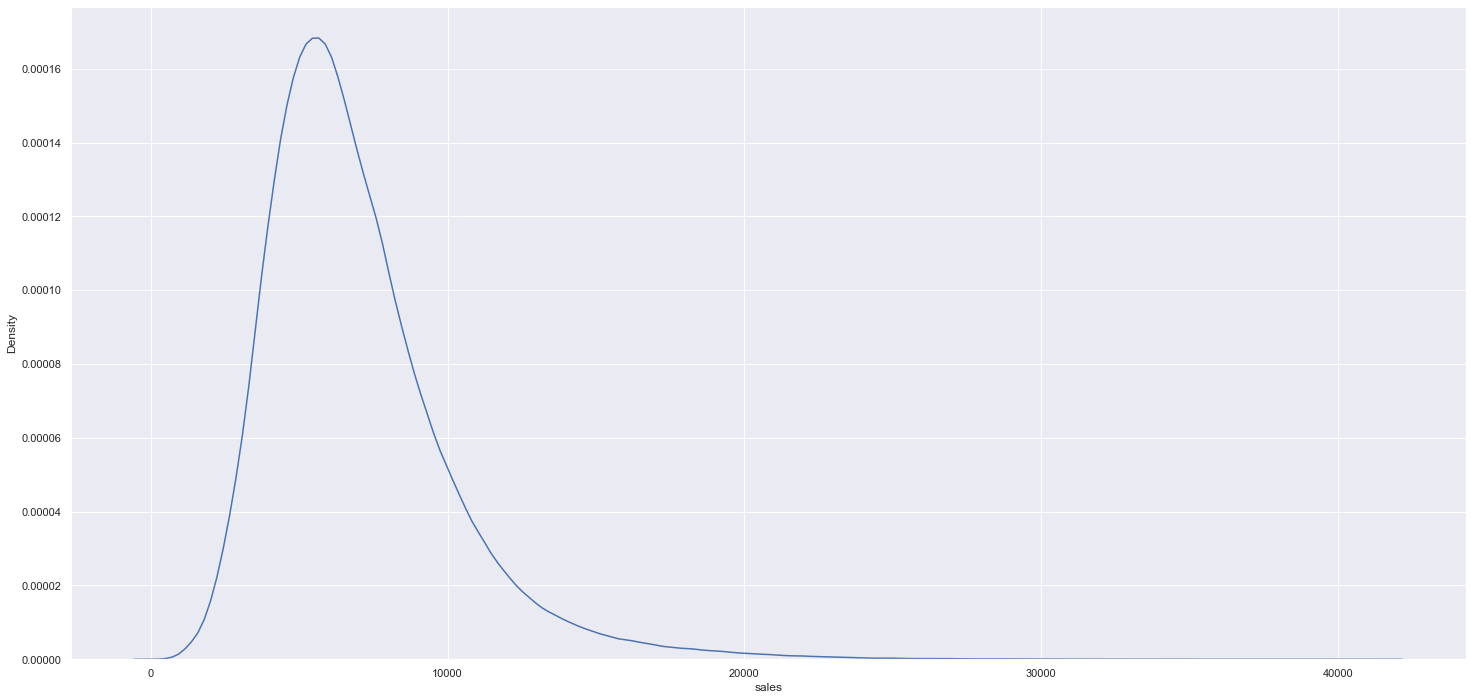

In [80]:
sns.kdeplot( data=df4, x='sales')

### 4.1.2. Numerical Variable


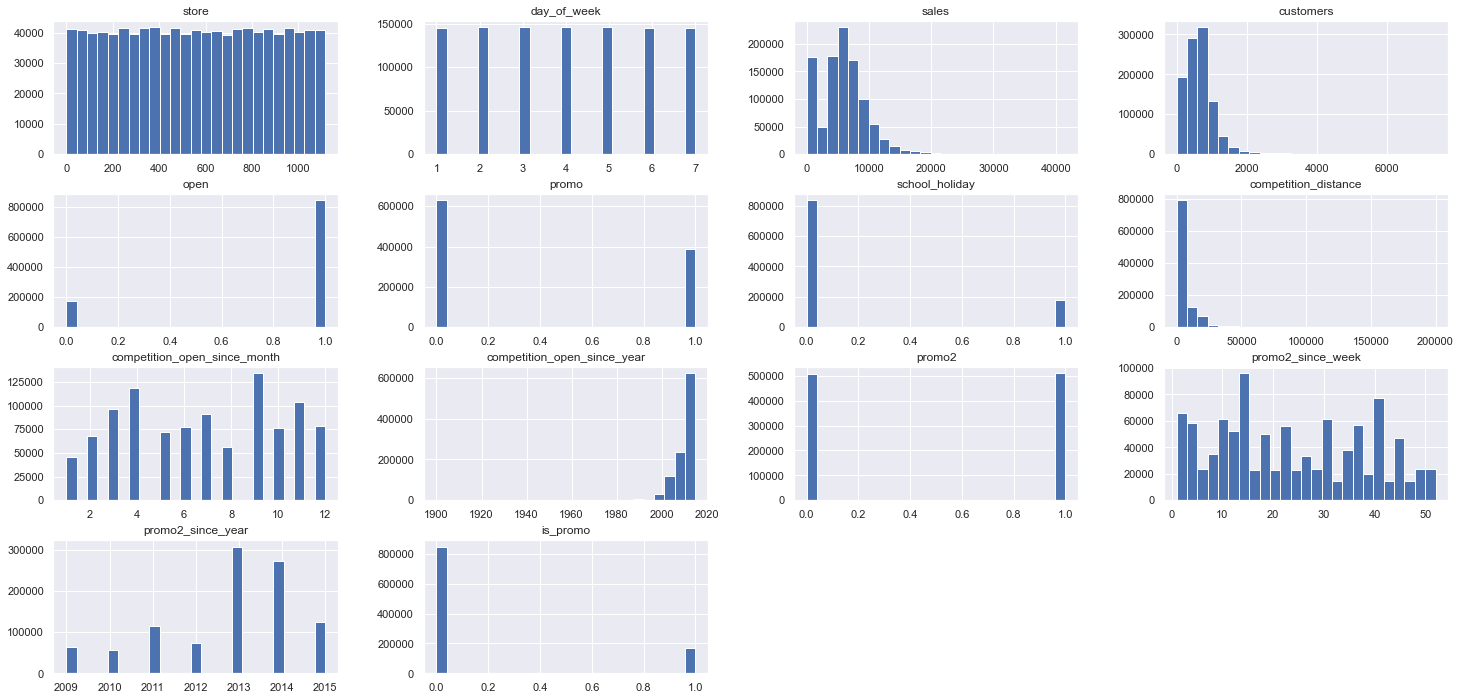

In [81]:
num_attributes.hist( bins=25);

### 4.1.3. Categorical Variable

In [82]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,,Jul
4,0,a,a,,Jul


In [84]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [85]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [99]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [100]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

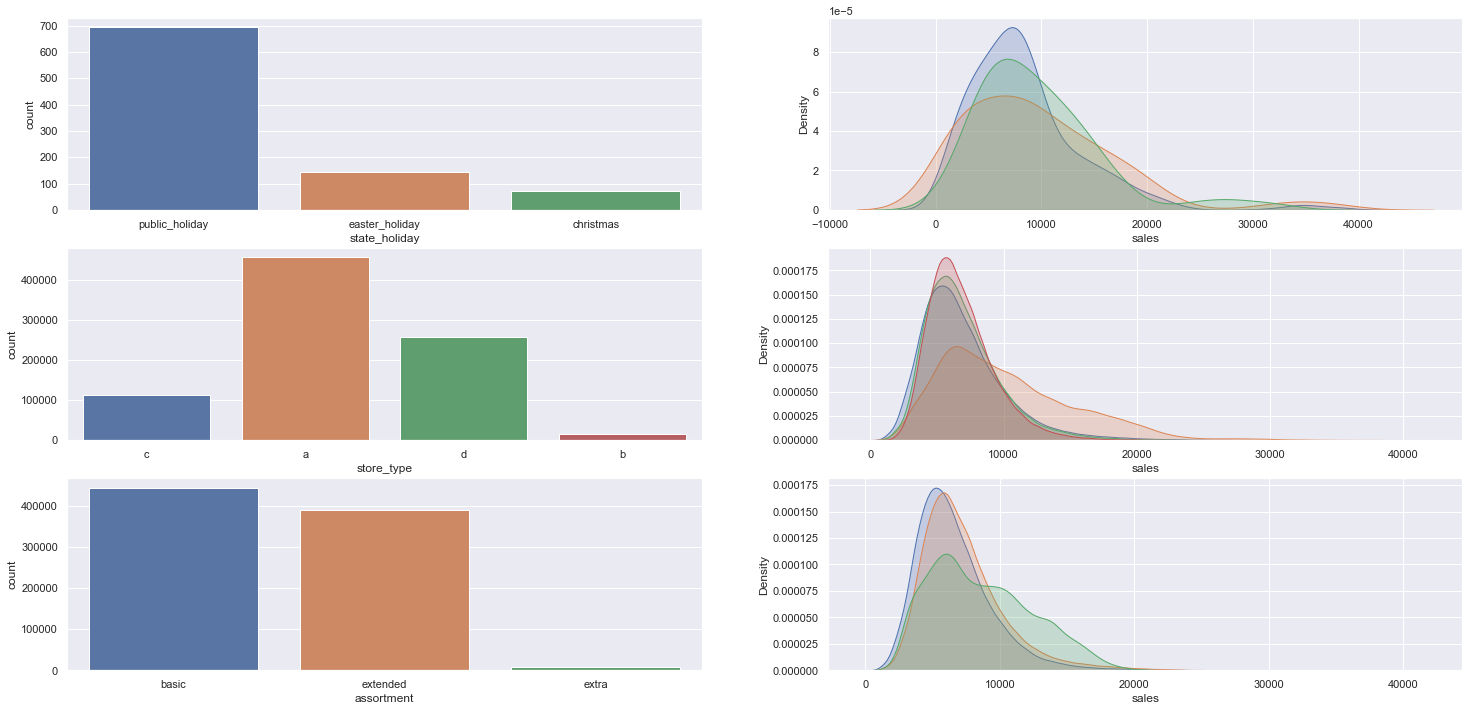

In [101]:
# state_holiday
plt.subplot(3,2,1)
dfa = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data= dfa, x=dfa['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot(3,2,3)
sns.countplot( data = df4, x=df4['store_type'])
                 
plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
                
# assortment
plt.subplot(3,2,5)
sns.countplot( data = df4, x=df4['assortment'])
                 
plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

                 
                 
                 

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='assortment', ylabel='sales'>

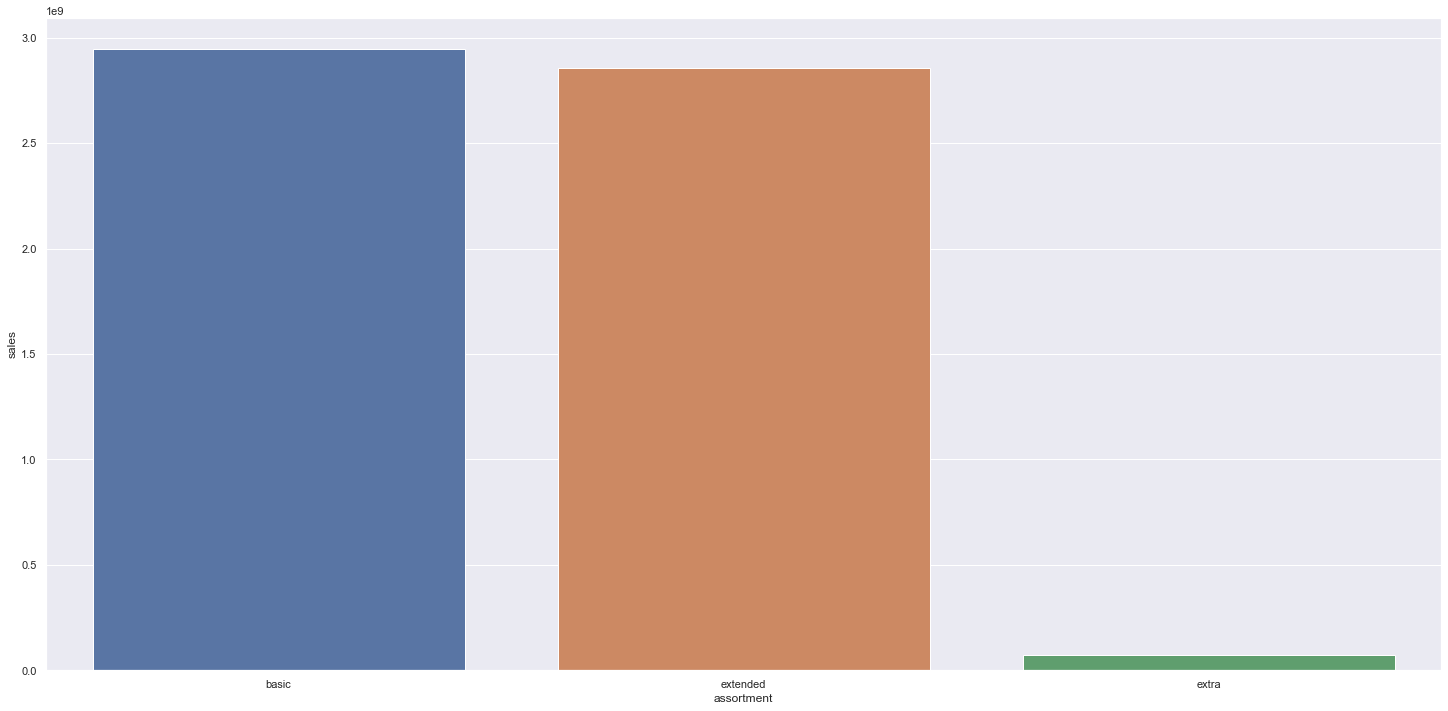

In [102]:
aux1 =df4[['assortment', 'sales']].groupby( 'assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

#### Insight - Assumindo que o Assortment Extra é oque possui maior sortimento, assumimos que a hipótese é falsa, tendo em vista que pelos dados apresentado, é oque possui menor quantidade de vendas.

<AxesSubplot:xlabel='year_week'>

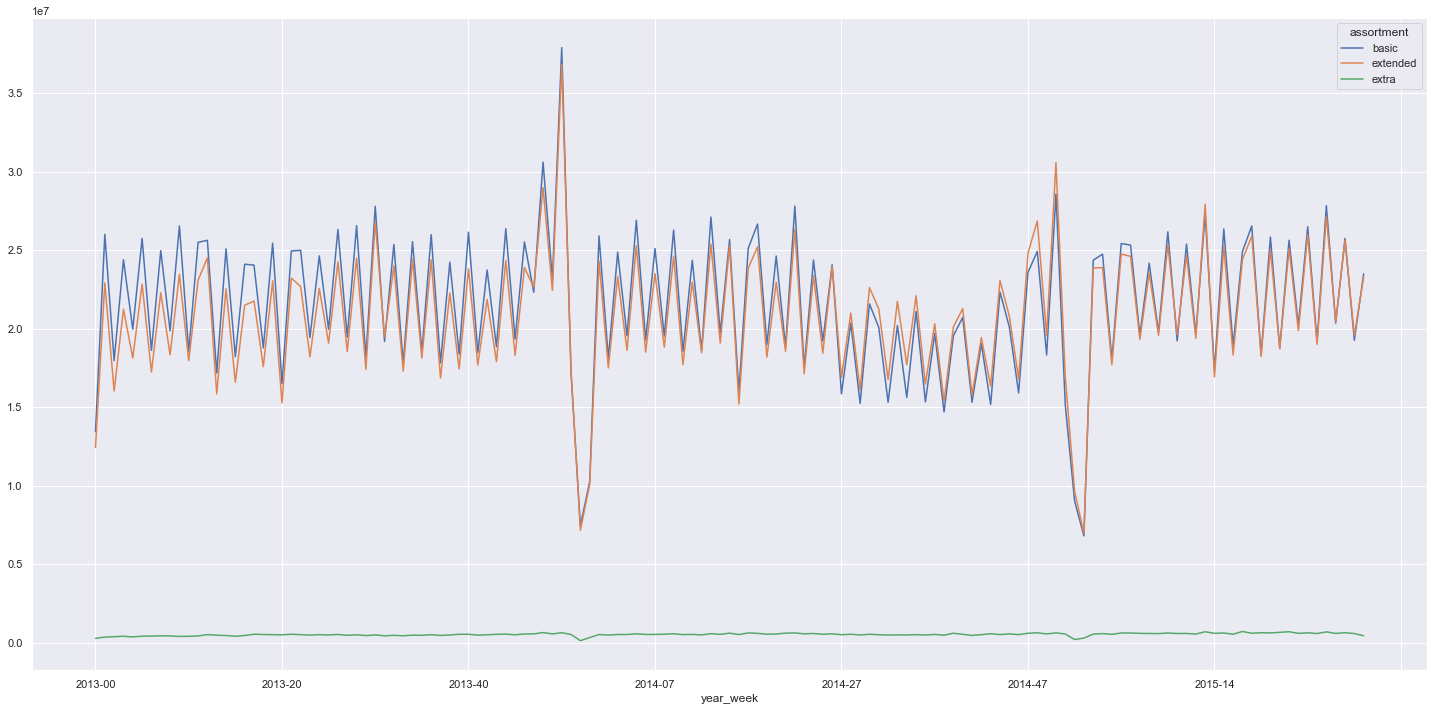

In [123]:
aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment',values='sales').plot()

#### Basic e Extended, possuem o mesmo comportamento ao longo do tempo, o Extra fica muito pequena nessa análise, necessário ver se comportamento sozinha

<AxesSubplot:xlabel='year_week'>

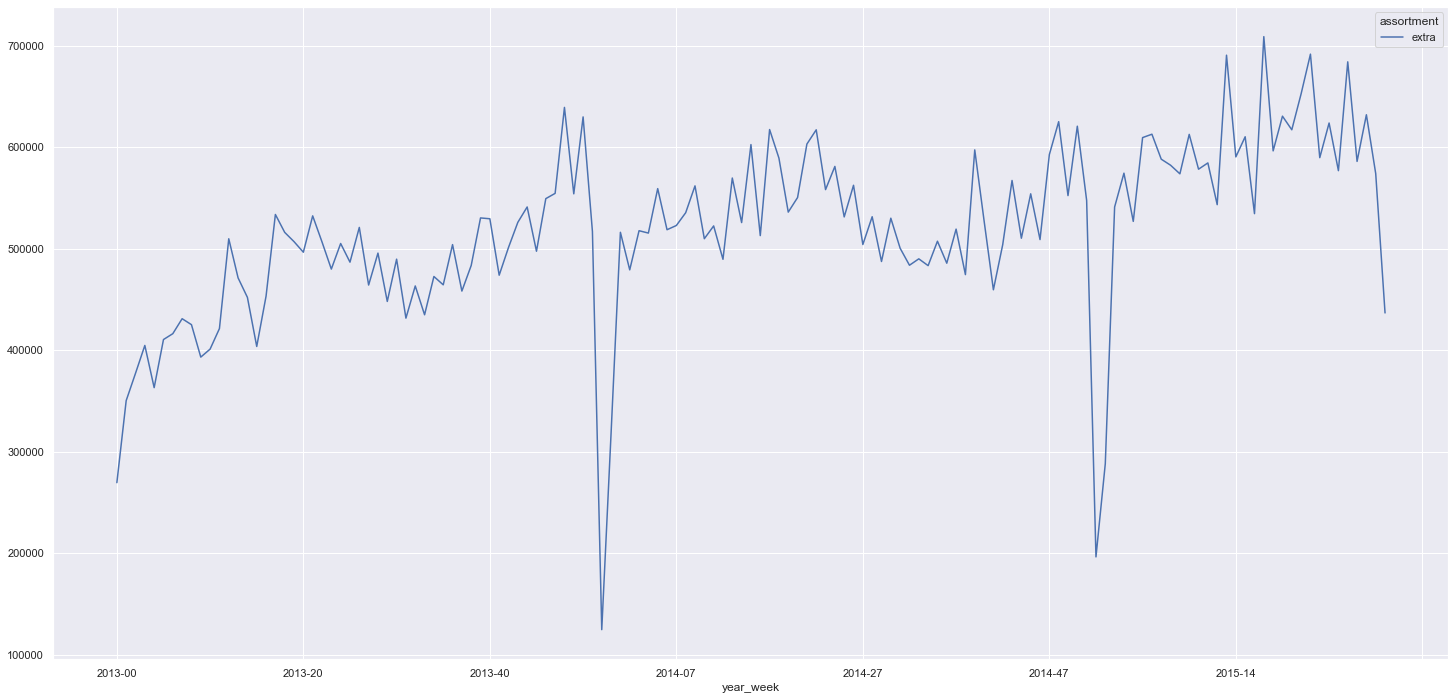

In [125]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment',values='sales').plot()

#### Interessante ver como que com uma escola diferente se observa uma variancia maior de vendas ao longo do tempo.

### H2. Lojas com mais dias de promoção deveriam vender mais.
**FALSA** Lojas com compedidores mais próximos vendem mais.

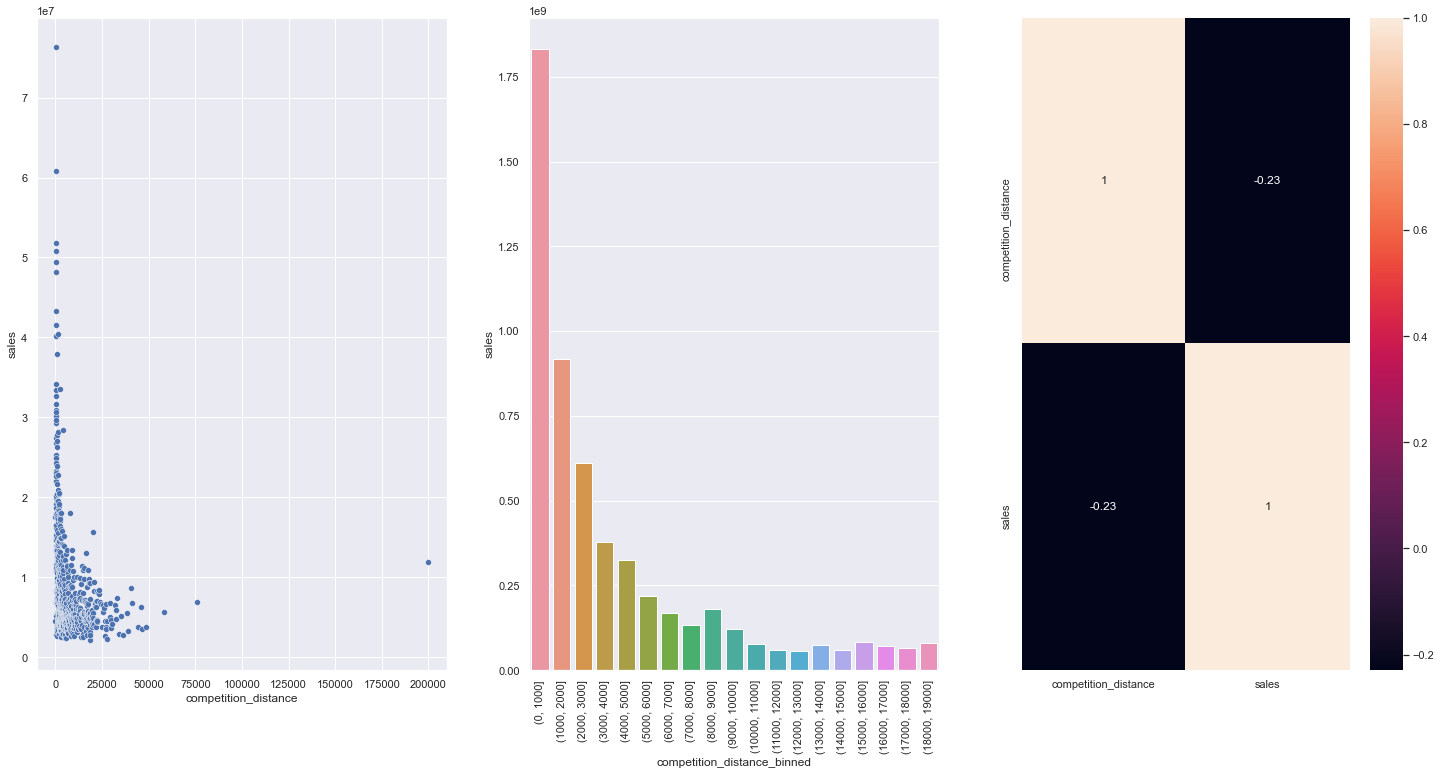

In [138]:
aux4 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux4);

plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut( aux4['competition_distance'],bins=bins)
aux5 = aux4[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux5);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap( aux4.corr( method='pearson'), annot=True);


#### Insight - Possível verificar que competidores mais próximos as lojas vendem mais do que com a distância maior.

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** quanto mais recente a competição, maior é a quantidade de vendas.

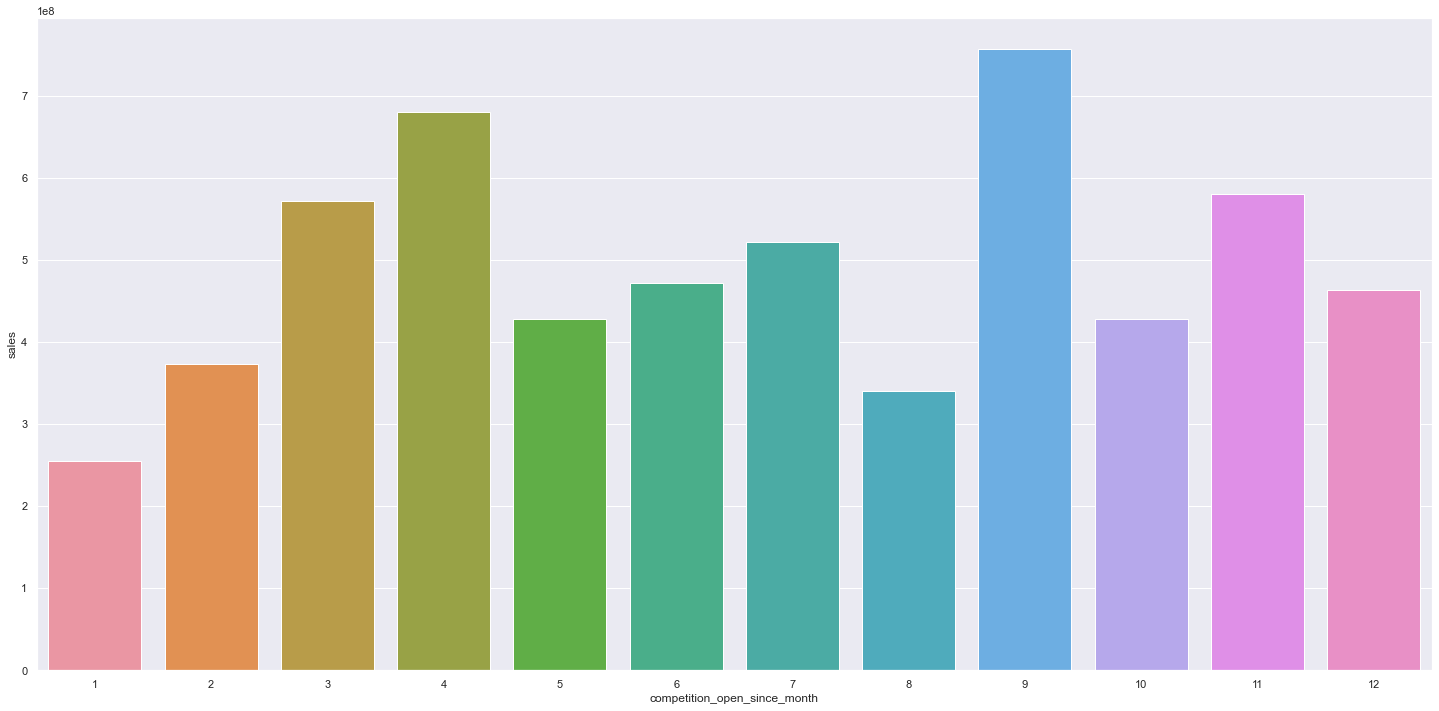

In [143]:
aux6 = df4[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month').sum().reset_index()
sns.barplot( x = 'competition_open_since_month', y ='sales', data=aux6);

#### Necessário realizar uma correlação melhor entre o inicio da competição é a quantidade de vendas.

<AxesSubplot:>

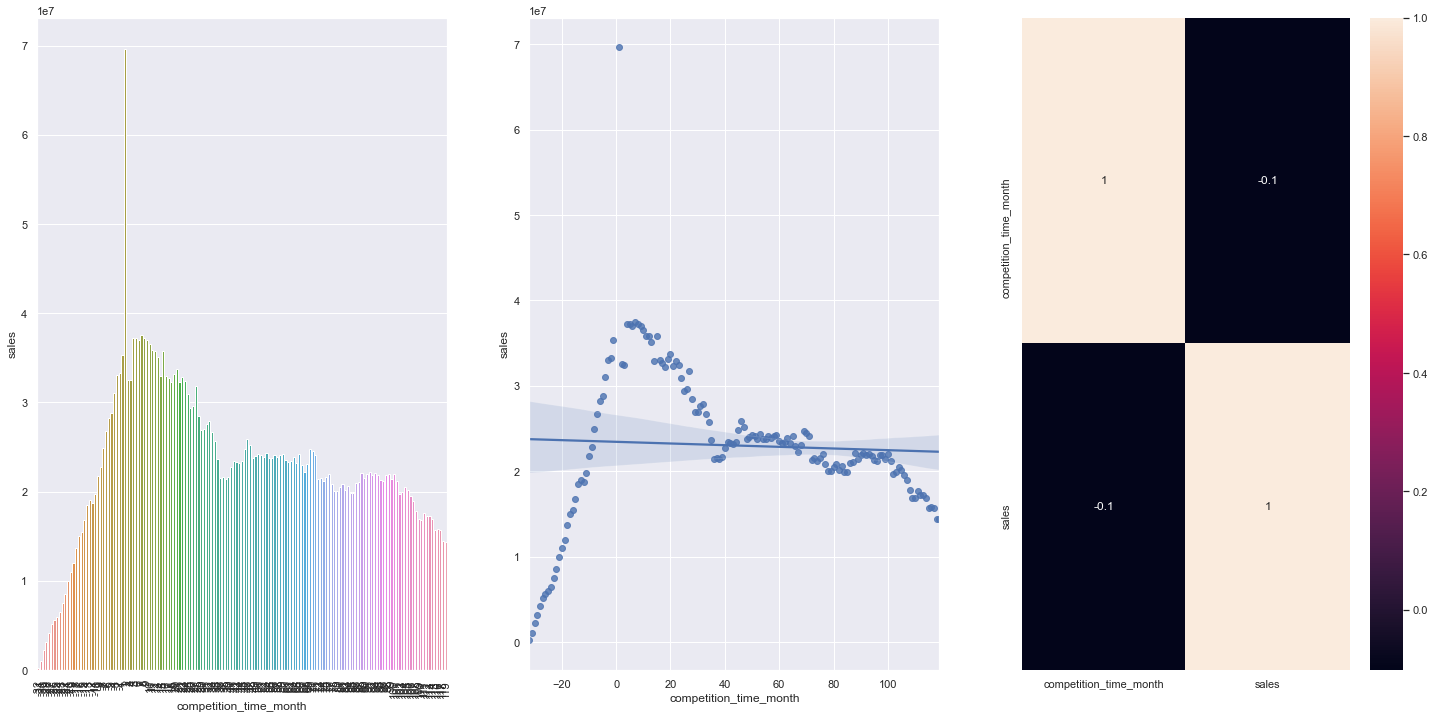

In [147]:
plt.subplot( 1,3,1)
aux7 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()
aux8 = aux7[(aux7['competition_time_month'] < 120 ) & (aux7['competition_time_month'] != 0)]
sns.barplot( x = 'competition_time_month', y ='sales', data=aux8);
plt.xticks( rotation= 90);

plt.subplot( 1,3,2)
sns.regplot( x = 'competition_time_month', y ='sales', data=aux8);

plt.subplot( 1,3,3)
sns.heatmap( aux7.corr( method='pearson'), annot=True)

#### Quanto mais recente, próximo de 0, maior é a quantidade de vendas.

## 4.3. Analise Multivariada